In [1]:
# %matplotlib widget
%matplotlib inline

In [2]:
import datetime as dt
from pathlib import Path
from typing import Sequence, Tuple, List

import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"   # 0 = all, 1 = INFO, 2 = WARNING, 3 = ERROR
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)

import pickle
import contextlib

import platform 
import sys
import math

import numpy as np
from numpy.lib.stride_tricks import sliding_window_view
import pandas as pd
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, metrics, mixed_precision
from tensorflow.keras.mixed_precision import LossScaleOptimizer
from tensorflow.keras.optimizers.schedules import CosineDecayRestarts, LearningRateSchedule
import torch

import matplotlib
import matplotlib.pyplot as plt         # ← for progress curves
from IPython.display import display, update_display, clear_output

from tqdm.auto import tqdm          # progress bars that work in Jupyter
from __future__ import annotations     # allows union types on Py <3.10

import stockanalibs


2025-06-20 16:48:57.961838: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750430937.984485   31250 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750430937.991474   31250 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1750430938.013018   31250 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1750430938.013044   31250 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1750430938.013046   31250 computation_placer.cc:177] computation placer alr

In [3]:
# os.environ["CUDA_VISIBLE_DEVICES"] = "" # to deactivate gpu
# tf.config.set_visible_devices([], 'GPU') # to deactivate gpu

print("Python :", platform.python_version(), "\n")
print("TF GPUs :", tf.config.list_physical_devices('GPU'))
print("Torch   :", torch.__version__, "CUDA-OK:", torch.cuda.is_available())


Python : 3.10.18 

TF GPUs : [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Torch   : 2.2.2+cu121 CUDA-OK: True


In [4]:
ticker = stockanalibs.ticker

df = pd.read_csv(f"dfs training/merged_{ticker}.csv", index_col=0, parse_dates=True)
df

,open,high,low,close,volume,bid,ask,trade_action,StrategyEarning,EarningDiff,signal_smooth_norm
2014-04-03 13:00:00,570.600,570.6000,570.600,570.6000,199.0,570.4288,570.7712,0,0.000,0.000,0.000000e+00
2014-04-03 13:01:00,570.800,570.8000,570.800,570.8000,135.0,570.6288,570.9712,0,0.000,0.000,4.764662e-13
2014-04-03 13:02:00,571.000,571.0000,570.750,570.7500,255.0,570.5788,570.9212,0,0.000,0.000,1.864650e-12
2014-04-03 13:03:00,570.750,570.7500,570.750,570.7500,261.0,570.5788,570.9212,0,0.000,0.000,5.087675e-12
2014-04-03 13:04:00,570.750,570.7500,570.750,570.7500,261.0,570.5788,570.9212,0,0.000,0.000,1.219857e-11
...,...,...,...,...,...,...,...,...,...,...,...
2025-06-18 20:56:00,173.375,173.6771,173.215,173.5650,621199.0,173.5129,173.6171,0,1.166,3.876,4.528500e-09
2025-06-18 20:57:00,173.565,173.5900,173.240,173.3800,624198.0,173.3280,173.4320,0,1.166,4.061,3.019000e-09
2025-06-18 20:58:00,173.390,173.4100,173.200,173.3100,454542.0,173.2580,173.3620,0,1.166,4.131,2.012667e-09
2025-06-18 20:59:00,173.315,173.4000,173.230,173.2800,1094746.0,173.2280,173.3320,0,1.166,4.161,1.341778e-09


In [5]:
###############################################################################
# 0 ·  DATA & PATHS                                                           #
###############################################################################
label_col      = "signal_smooth_norm"

feature_cols   = ["open", "high", "low", "close", "volume"]
LOOK_BACK      = stockanalibs.look_back                                
N_FEATS        = len(feature_cols) * LOOK_BACK     # final feature length

import datetime as dt
rth_start      = dt.time(14, 30)                   # US cash-open in CET/CEST

from pathlib import Path
save_dir       = Path("dfs training")
ckpt_path      = save_dir / f"best_{ticker}.weights.h5"   # auto-per‐ticker

# dataset split proportions
TRAIN_PROP, VAL_PROP = 0.70, 0.15                 # → 0.15 test remainder


###############################################################################
# 1 ·  MODEL HYPER-PARAMETERS (tuned defaults)                                 #
###############################################################################
# ── architecture ───────────────────────────────────────────────────────
SHORT_UNITS        = 64      # double → better GPU fill, little over-fit risk
LONG_UNITS         = 128
DROPOUT_SHORT      = 0.20    # applied AFTER the LSTM layer
DROPOUT_LONG       = 0.15
REC_DROP_SHORT     = 0.0     # MUST be 0.0 for fused kernel
REC_DROP_LONG      = 0.0

# ── optimiser : cosine-decay-restarts ──────────────────────────────────
INITIAL_LR         = 1e-4    # slightly cooler for bigger network
FIRST_DECAY_EPOCHS = 5       # first valley arrives early
T_MUL              = 2.0
M_MUL              = 1.0
ALPHA              = 0.05
LOSS_FN            = "mse"
CLIPNORM           = 1.0

# ── training control ───────────────────────────────────────────────────
TRAIN_BATCH        = 64      # GPU now uses more threads; fits on 8-12 GB
VAL_BATCH          = 1
MAX_EPOCHS         = 90
EARLY_STOP_PATIENCE= 15
USE_FP16           = True




In [6]:
###############################################################################
# build_lstm_tensors                                                          #
# --------------------------------------------------------------------------- #
# Converts **one big minute-bar DataFrame (many days)** into two leakage-free #
# NumPy arrays ready for the stateful LSTM:                                   #
#                                                                             #
#   X  – design matrix; every row is a eg 60-min (or `look_back`) window         #
#        flattened to 1-D:  (look_back × n_features,)                         #
#   y  – the single-step-ahead target corresponding to the *last* row         #
#        in that window.                                                      #
#                                                                             #
# RULES ENFORCED                                                              #
# • Windows never cross midnight → yesterday’s RTH info can’t leak into the   #
#   first prediction of the new day.                                          #
# • The very first RTH window of the day uses ONLY pre-trade minutes.         #
# • Features are **standardised per day** (mean-0 / std-1) so levels &        #
#   volumes that drift day-to-day don’t leak statistics across sessions.      #
# • Output dtype = float32 (GPU-friendly & half the RAM of float64).          #
# • Entire routine is vectorised with `np.lib.stride_tricks.sliding_window_view`
#   ⇒ no Python loop over 391 minutes → 40× faster than naive for-loops.      #
###############################################################################

def build_lstm_tensors(
    df: pd.DataFrame,
    *,
    look_back: int,
    feature_cols: Sequence[str],
    label_col: str,
    rth_start: dt.time,                # e.g. 14:30 CET for US equities
    flatten: bool = True               # keep 2-D (N, L·F) by default
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Parameters
    ----------
    df : pd.DataFrame
        One-minute OHLCV bars **for many calendar days**.  DatetimeIndex
        must be tz-aware & strictly increasing (no duplicates).
    look_back : int
        Size of the sliding window in minutes (e.g. 60).
    feature_cols : list[str]
        Names of numeric feature columns to feed the network.
    label_col : str
        Name of the 1-step-ahead target column (already computed).
    rth_start : datetime.time
        Clock time that marks the first minute of **regular trading hours**.
        Every minute whose index.time ≥ rth_start is considered “tradable”.
    flatten : bool
        • True  →  X rows are 1-D vectors  (L·F,)  → matches our current
                   `make_day_dataset` reshape → lighter I/O.
        • False →  X rows keep shape  (L, F)     → nicer for exploratory
                   notebook charting, but slower to feed into tf.data.

    Returns
    -------
    X : np.ndarray (N, L·F)  *or* (N, L, F)
        Design matrix.  N = (#days × intraday minutes) − look_back.
    y : np.ndarray (N,)
        Targets aligned 1:1 with X rows.
    """

    X_rows, y_rows = [], []                    # collectors

    # 1. process *one calendar day* at a time (prevents inter-day leakage)
    for date, day_df in df.groupby(df.index.normalize()):

        day_df = day_df.sort_index()

        # 1-A. per-day standard-scaling of *features*
        day_df[feature_cols] = StandardScaler().fit_transform(
                                   day_df[feature_cols])

        feats_np  = day_df[feature_cols].to_numpy(dtype=np.float32)   # (T, F)
        label_np  = day_df[label_col]     .to_numpy(dtype=np.float32) # (T,)

        # Boolean mask of rows that belong to regular trading hours
        rth_mask = day_df.index.time >= rth_start
        if not rth_mask.any():                      # holiday / half-day
            continue

        T, F = feats_np.shape                      # minute-rows in this day

        # 2. build all candidate windows (vectorised)
        #
        # sliding_window_view gives (T-L+1, L, F)
        win_3d = sliding_window_view(
                     feats_np,
                     (look_back, F),
                     axis=(0, 1))[:, 0, :, :]      # squeeze spurious dim

        # ── ALIGNMENT FIX ──────────────────────────────────────────────
        # win_3d has length  T-look_back+1
        # labels available for prediction run from index look_back .. T-1
        # → exactly  T-look_back  entries
        win_3d   = win_3d[:-1]                    # drop the *last* window
        y_aligned = label_np[look_back:]          # (T-L,)

        # also trim the RTH mask so it matches the new length
        rth_mask_shifted = rth_mask[look_back:]   # (T-L,)

        # keep only windows whose **target** timestamp is inside RTH
        win_3d   = win_3d[  rth_mask_shifted]
        y_aligned = y_aligned[rth_mask_shifted]

        # final representation
        if flatten:
            X_rows.append(win_3d.reshape(win_3d.shape[0], -1))  # (N_d, L·F)
        else:
            X_rows.append(win_3d)                               # (N_d, L, F)

        y_rows.append(y_aligned)

    # 3. concatenate across all calendar days
    if not X_rows:
        raise ValueError("No RTH rows found – check rth_start or data gaps.")

    X = np.concatenate(X_rows).astype(np.float32)
    y = np.concatenate(y_rows).astype(np.float32)

    return X, y


In [7]:
X, y = build_lstm_tensors(df=df,
                         look_back=LOOK_BACK,         
                         feature_cols=feature_cols,
                         label_col=label_col,
                         rth_start=rth_start)

print(X.shape) # we use 'm' features and 'n' previous look back values to predict each 1 label
print(y.shape) # 'n' lookback values * 'n_days_df' (all pretrade values) are deducted from the original df shape

(1074090, 450)
(1074090,)


In [8]:
###############################################################################
# chronological_split  – v2 (vectorised, exhaustively commented)              #
# --------------------------------------------------------------------------- #
# Converts the *sample–level* tensors (X, y) produced by `build_lstm_tensors` #
# into three chronological blocks: train / validation / test.                 #
#                                                                             #
# HOW IT WORKS                                                                #
# 1.  Computes, for every calendar day, **how many windows survived** the     #
#     `build_lstm_tensors()` rules.  We do this WITHOUT iterating minute-by-  #
#     minute:                                                                 #
#           usable_windows = max(0, #RTH_rows  –  look_back)                  #
#     because build_lstm_tensors dropped the first `look_back` labels in each #
#     day and then kept only those whose TARGET timestamp ∈ RTH.              #
#                                                                             #
# 2.  Builds a `day_id` vector so each row in X knows from which date it came.#
#     This lets downstream tf.data pipelines re-assemble full days.           #
#                                                                             #
# 3.  Slices X & y purely by **day boundaries** (not sample indices) so all   #
#     windows that belong to the same calendar day end up in the same split.  #
#                                                                             #
# 4.  Returns:                                                                #
#     • the three splits (X_tr, y_tr) / (X_val, y_val) / (X_te, y_te)         #
#     • `samples_per_day`  – diagnostic array, can drive batch padding sizes  #
#     • `day_id_*` vectors  – handy for make_day_dataset()                    #
###############################################################################

def chronological_split(
    X: np.ndarray,
    y: np.ndarray,
    df: pd.DataFrame,           # same DataFrame used to build X, y
    *,
    look_back: int,
    rth_start: dt.time,
    train_prop: float,
    val_prop: float,
) -> Tuple[
        Tuple[np.ndarray, np.ndarray],    # train tensors
        Tuple[np.ndarray, np.ndarray],    # val   tensors
        Tuple[np.ndarray, np.ndarray],    # test  tensors
        List[int],                        # samples_per_day
        np.ndarray, np.ndarray, np.ndarray  # day_id train / val / test
    ]:
    """
    Splits `X, y` into chronological train/val/test by **whole days**.

    Returns
    -------
    (X_train, y_train), (X_val, y_val), (X_test, y_test)
    samples_per_day : list[int]
        Number of usable windows contributed by each day.
    day_id_tr / day_id_val / day_id_te : np.ndarray
        For every sample in each split, which day (0-based) it came from.
        These are needed by make_day_dataset() to pad & batch whole days.
    """

    # ──────────────────────────────────────────────────────────────────
    # 1. Re-count usable windows per calendar day  (vectorised, exact) #
    # ──────────────────────────────────────────────────────────────────
    samples_per_day: List[int] = []

    for _, day_df in df.groupby(df.index.normalize(), sort=False):
        T = len(day_df)                              # minute rows today
        idx = np.arange(T)                           # 0 … T-1

        mask_window_ready = idx >= look_back         # enough history
        mask_rth_target  = day_df.index.time >= rth_start
        usable_today     = int(np.count_nonzero(mask_window_ready & mask_rth_target))

        samples_per_day.append(usable_today)

    # Safety: summed count must equal len(X)
    if sum(samples_per_day) != len(X):
        raise ValueError(
            "Length mismatch between counted windows and X. "
            "Ensure look_back & rth_start match build_lstm_tensors()."
        )

    # ──────────────────────────────────────────────────────────────────
    # 2. Build the day_id vector (one int tag per sample)              #
    # ──────────────────────────────────────────────────────────────────
    day_id = np.repeat(np.arange(len(samples_per_day)), samples_per_day)

    # ──────────────────────────────────────────────────────────────────
    # 3. Determine split cut-points in **day space**                   #
    # ──────────────────────────────────────────────────────────────────
    last_day = len(samples_per_day) - 1
    cut_train = int(last_day * train_prop)
    cut_val   = int(last_day * (train_prop + val_prop))

    mask_tr =  day_id <= cut_train
    mask_va = (day_id >  cut_train) & (day_id <= cut_val)
    mask_te =  day_id >  cut_val

    # ──────────────────────────────────────────────────────────────────
    # 4. Slice tensors                                                 #
    # ──────────────────────────────────────────────────────────────────
    X_tr, y_tr = X[mask_tr], y[mask_tr]
    X_va, y_va = X[mask_va], y[mask_va]
    X_te, y_te = X[mask_te], y[mask_te]

    # ──────────────────────────────────────────────────────────────────
    # 5. Return everything                                             #
    # ──────────────────────────────────────────────────────────────────
    return (X_tr, y_tr), (X_va, y_va), (X_te, y_te), \
           samples_per_day, \
           day_id[mask_tr], day_id[mask_va], day_id[mask_te]


In [9]:
# call the splitter  ─────────────────────────────────────────────
(X_tr, y_tr), (X_val, y_val), (X_te, y_te), samples_per_day, \
day_id_tr, day_id_val, day_id_te = chronological_split(
        X, y, df,
        look_back=LOOK_BACK,
        rth_start=rth_start,
        train_prop=TRAIN_PROP,
        val_prop=VAL_PROP
)

# ─── NEW: force train days to k·32 so no remainder is ever dropped ───────
unique_days_tr = np.unique(day_id_tr)
n_train_days   = len(unique_days_tr)
keep_days      = (n_train_days // TRAIN_BATCH) * TRAIN_BATCH     # largest multiple
days_to_keep   = set(unique_days_tr[:keep_days])                 # earliest days
train_keep_mask = np.isin(day_id_tr, list(days_to_keep))

# slice again, but only on train tensors
X_tr  = X_tr[train_keep_mask]
y_tr  = y_tr[train_keep_mask]
day_id_tr = day_id_tr[train_keep_mask]

print(f"Training days kept : {keep_days}  (multiple of {TRAIN_BATCH})")
print(f"Validation days    : {len(np.unique(day_id_val))}")
print(f"Test days          : {len(np.unique(day_id_te))}")


Training days kept : 1920  (multiple of 64)
Validation days    : 422
Test days          : 423


In [10]:
###############################################################################
# make_day_dataset  (weekday-safe, glare-free)                            #
# --------------------------------------------------------------------------- #
# PURPOSE                                                                     #
# Take minute-level samples X, y (already leakage-free) and yield **exactly   #
# ONE `tf.data` element per calendar day**.                                   #
# Each element carries:                                                       #
#      x_day   (1 , T , n_feats)  – the whole RTH session                     #
#      y_day   (1 , T)            – its labels                                #
#      weekday scalar int32       – 0=Mon … 6=Sun (from the REAL calendar)    #
# The weekday is later used by the training loop to decide when to reset the  #
# “long” LSTM state (only on week-end).                                       #
#                                                                             #
# DESIGN NOTES                                                                #
# •  The function stays NumPy-vectorised; only ~1 000 generator yields per    #
#    epoch, so Python overhead is negligible.                                 #
# •  No dependency on the original DataFrame – we pass `weekday_vec` that     #
#    came straight from the DatetimeIndex.                                    #
###############################################################################

def make_day_dataset(
    X           : np.ndarray,          # (N , …)
    y           : np.ndarray,          # (N ,)
    day_id      : np.ndarray,          # (N ,)  strictly ascending
    weekday_vec : np.ndarray,          # (N ,)  real weekday of every row
) -> tf.data.Dataset:
    """
    Returns
    -------
    tf.data.Dataset
        element = (x_day, y_day, weekday)
        x_day : (1 , T , n_feats)  float32
        y_day : (1 , T)            float32
        weekday : () int32
    """

    # ── 1. Chronological safety – keep everything sorted the same way ─────
    idx = np.argsort(day_id, kind="stable")
    X, y, day_id, weekday_vec = [a[idx] for a in (X, y, day_id, weekday_vec)]

    # ── 2. Build slices for each distinct day_id (vectorised) ─────────────
    change      = np.where(np.diff(day_id) != 0)[0] + 1      # breakpoints
    day_slices  = np.split(np.arange(len(day_id)), change)   # list[np.ndarray]

    # ── 3. Python generator : ONE yield == one calendar day ───────────────
    def gen():
        for sl in day_slices:
            x_block = X[sl]                        # (T , …)
            y_block = y[sl]                        # (T ,)
            weekday = int(weekday_vec[sl[0]])      # real weekday, 0–6

            # add batch dimension expected by stateful LSTM
            yield (
                np.expand_dims(x_block, 0).astype(np.float32),  # (1 , T , …)
                np.expand_dims(y_block, 0).astype(np.float32),  # (1 , T)
                np.int32(weekday),
            )

    # ── 4. Static signature (time axis None → variable length) ────────────
    feat_shape = X.shape[1:]                                   # supports (L·F) or (L, F)
    output_signature = (
        tf.TensorSpec((1, None, *feat_shape), tf.float32),      # x_day
        tf.TensorSpec((1, None),              tf.float32),      # y_day
        tf.TensorSpec((),                    tf.int32),         # weekday
    )

    return (
        tf.data.Dataset.from_generator(gen, output_signature=output_signature)
          .prefetch(tf.data.AUTOTUNE)        # overlaps CPU ↔ GPU copies
    )


In [11]:
###############################################################################
# split_to_day_datasets  –  zero-copy, minimal arguments                     #
###############################################################################
# One call returns three ready-to-feed pipelines:
#   ds_train_batched   → (TRAIN_BATCH , T_max , n_feats) per step
#   ds_val_unbatched   → (1  , T ,    n_feats) per step
#   ds_test_unbatched  → idem  (optional)
###############################################################################

def split_to_day_datasets(
        X_tr,  y_tr,  day_id_tr,
        X_val, y_val, day_id_val,
        X_te,  y_te,  day_id_te,
        *,
        df,                 # full DataFrame (for weekday lookup)
        train_batch: int
) -> Tuple[tf.data.Dataset, tf.data.Dataset, tf.data.Dataset]:
    """
    Parameters
    ----------
    X_tr , y_tr , day_id_tr  : np.ndarray  – chronological, no gaps
    X_val, y_val, day_id_val : np.ndarray
    X_te , y_te , day_id_te  : np.ndarray
    df                       : original DataFrame used to build X/y
    train_batch              : how many days per “fat” training batch

    Returns
    -------
    ds_train_batched , ds_val_unbatched , ds_test_unbatched
    """

    # ── 1. Build one weekday vector covering ALL samples ──────────────────
    weekday_all = df.index.dayofweek.to_numpy(dtype=np.int8)   # (N,)

    # Because X_tr, X_val, X_te are sequential slices, we can split by length
    n_tr  = len(X_tr)
    n_val = len(X_val)
    n_te  = len(X_te)

    weekday_vec_tr  = weekday_all[:n_tr]
    weekday_vec_val = weekday_all[n_tr : n_tr + n_val]
    weekday_vec_te  = weekday_all[n_tr + n_val : n_tr + n_val + n_te]

    # ── 2. Convert each split to “one day → one element” datasets ─────────
    ds_tr   = make_day_dataset(X_tr,  y_tr,  day_id_tr,  weekday_vec_tr)
    ds_val  = make_day_dataset(X_val, y_val, day_id_val, weekday_vec_val)
    ds_test = make_day_dataset(X_te,  y_te,  day_id_te,  weekday_vec_te)

    # ── 3. TRAIN pipeline – strip batch-1 dim, pad to fixed length ───────
    def _strip(x_day, y_day, wd):
        return tf.squeeze(x_day, 0), tf.squeeze(y_day, 0), wd   # (T , …)

    ds_train_batched = (
        ds_tr
          .map(_strip, num_parallel_calls=tf.data.AUTOTUNE)
          .padded_batch(train_batch, drop_remainder=True)
          .prefetch(tf.data.AUTOTUNE)
    )

    # ── 4. Return ready-to-feed pipelines ────────────────────────────────
    return ds_train_batched, ds_val, ds_test


In [12]:
ds_train_batched, ds_val_unbatched, ds_test_unbatched = split_to_day_datasets(
        X_tr, y_tr, day_id_tr,
        X_val, y_val, day_id_val,
        X_te, y_te, day_id_te,
        df=df,
        train_batch=TRAIN_BATCH)

I0000 00:00:1750430963.258226   31250 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6096 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2070 with Max-Q Design, pci bus id: 0000:01:00.0, compute capability: 7.5


In [13]:
'''
                       (inference / trading time)

┌──────────────────────────────────────────────────────────────────────────┐
│ ❶  NETWORK  WEIGHTS  θ  – learned across all history, fixed at runtime   │
└──────────────────────────────────────────────────────────────────────────┘
        │
        ▼
┌──────────────────────────────────────────────────────────────────────────┐
│ ❷  CELL STATE  cₜ  – slow integrator covering the *whole* current day    │
│    • retains early-morning context                                       │
│    • reset_states()  at every midnight → zero on next session            │
└──────────────────────────────────────────────────────────────────────────┘
        │
        ▼
┌──────────────────────────────────────────────────────────────────────────┐
│ ❸  HIDDEN STATE  hₜ  – fast dynamics (a few bars)                        │
│    • captures spikes / micro-structure                                   │
│    • reset together with cₜ midnight                                     │
└──────────────────────────────────────────────────────────────────────────┘
        │
        ▼
┌──────────────────────────────────────────────────────────────────────────┐
│ ❹  INPUT WINDOW  xₜ  – last 60 minutes of raw features                   │
│    • first RTH prediction uses 60 *pre-trade* minutes only               │
│    • later predictions mix pre-trade + today’s RTH, never yesterday RTH  │
└──────────────────────────────────────────────────────────────────────────┘
        │
        ▼
                        Predicted signal ŷₜ


Day i                               Day i+1
|────────────┬──────────────┬───…──┬────────┐
08:00        09:30        16:00   08:00    09:30
pre-trade       RTH                pre-trade  RTH
cₜ,hₜ: 0 → accumulate → reset_states() → 0 → accumulate


'''

'\n                       (inference / trading time)\n\n┌──────────────────────────────────────────────────────────────────────────┐\n│ ❶  NETWORK  WEIGHTS  θ  – learned across all history, fixed at runtime   │\n└──────────────────────────────────────────────────────────────────────────┘\n        │\n        ▼\n┌──────────────────────────────────────────────────────────────────────────┐\n│ ❷  CELL STATE  cₜ  – slow integrator covering the *whole* current day    │\n│    • retains early-morning context                                       │\n│    • reset_states()  at every midnight → zero on next session            │\n└──────────────────────────────────────────────────────────────────────────┘\n        │\n        ▼\n┌──────────────────────────────────────────────────────────────────────────┐\n│ ❸  HIDDEN STATE  hₜ  – fast dynamics (a few bars)                        │\n│    • captures spikes / micro-structure                                   │\n│    • reset together with cₜ midnight    

In [14]:
###############################################################################
# build_stateful_lstm_dual                                                    #
# --------------------------------------------------------------------------- #
# Creates a two-tier stateful network:                                        #
#   • Layer 0  “short_lstm”  (SHORT_UNITS units)  → quick dynamics, daily reset        #
#   • Layer 1  “long_lstm”   (LONG_UNITS units)  → slow drift, weekly reset           #
#                                                                             #
# You decide what “week” means by calling reset_states() on long_lstm         #
# whenever your outer loop hits Saturday close or Sunday 00:00.               #
###############################################################################


def build_stateful_lstm_dual(
        *,
        n_feats: int,
        batch_size: int,

        # architecture
        short_units: int,
        long_units:  int,
        dropout_short:    float,
        dropout_long:     float,
        rec_drop_short:   float,
        rec_drop_long:    float,

        # optimiser schedule
        initial_lr:       float,
        first_decay_steps:int,     # *absolute* #gradient steps
        t_mul:   float,
        m_mul:   float,
        alpha:   float,

        # misc
        loss:            str,
        clipnorm:        float,
        use_mixed_fp16:  bool
) -> tf.keras.Model:
    """
    Returns a compiled two-tier LSTM (daily + weekly memory).
    Pass *absolute* `first_decay_steps` (in gradient updates, not epochs).
    """

    # ── 1 · optional mixed-precision context ────────────────────────────
    prev_policy = mixed_precision.global_policy().name
    if use_mixed_fp16 and prev_policy != "mixed_float16":
        mixed_precision.set_global_policy("mixed_float16")

    # ── 2 · network definition ─────────────────────────────────────────
    inp = layers.Input(batch_shape=(batch_size, None, n_feats), name="inp")

    x = layers.LSTM(short_units,
                    stateful=True,
                    return_sequences=True,
                    dropout=0, #dropout_short,
                    recurrent_dropout=0, #rec_drop_short,
                    kernel_initializer="orthogonal",
                    name="short_lstm")(inp)
    x = layers.Dropout(dropout_short)(x)
    x = layers.LayerNormalization(name="ln_short")(x)

    x = layers.LSTM(long_units,
                    stateful=True,
                    return_sequences=True,
                    dropout=0, #dropout_long,
                    recurrent_dropout=0, #rec_drop_long,
                    kernel_initializer="orthogonal",
                    name="long_lstm")(x)
    x = layers.Dropout(dropout_long)(x)
    x = layers.LayerNormalization(name="ln_long")(x)

    out = layers.TimeDistributed(layers.Dense(1), name="pred")(x)
    model = models.Model(inp, out, name="dual_mem_lstm")

    # ── 3 · optimiser & schedule ───────────────────────────────────────
    lr_sched = tf.keras.optimizers.schedules.CosineDecayRestarts(
        initial_learning_rate = initial_lr,
        first_decay_steps     = first_decay_steps,
        t_mul                 = t_mul,
        m_mul                 = m_mul,
        alpha                 = alpha
    )
    opt = optimizers.Adam(learning_rate=lr_sched, clipnorm=clipnorm)
    model.compile(optimizer=opt,
                  loss      = loss,
                  metrics   =[metrics.RootMeanSquaredError(name="rmse")])

    # ── 4 · restore dtype policy outside mixed-FP16 scope ──────────────
    if mixed_precision.global_policy().name != prev_policy:
        mixed_precision.set_global_policy(prev_policy)

    return model


In [15]:
###############################################################################
# BUILD THE TWO STATEFUL COPIES                                          #
###############################################################################
# fast FP16 train graph
model_train = build_stateful_lstm_dual(
    n_feats           = N_FEATS,
    batch_size        = TRAIN_BATCH,
    short_units       = SHORT_UNITS,
    long_units        = LONG_UNITS,
    dropout_short     = DROPOUT_SHORT,
    dropout_long      = DROPOUT_LONG,
    rec_drop_short    = REC_DROP_SHORT,
    rec_drop_long     = REC_DROP_LONG,
    initial_lr        = INITIAL_LR,
    first_decay_steps = FIRST_DECAY_EPOCHS,
    t_mul             = T_MUL,
    m_mul             = M_MUL,
    alpha             = ALPHA,
    loss              = LOSS_FN,
    clipnorm          = CLIPNORM,
    use_mixed_fp16    = USE_FP16)

#  plain FP32 validation / inference graph
model_val = build_stateful_lstm_dual(
    n_feats           = N_FEATS,
    batch_size        = VAL_BATCH,      # always 1 for day-by-day eval
    short_units       = SHORT_UNITS,
    long_units        = LONG_UNITS,
    dropout_short     = DROPOUT_SHORT,
    dropout_long      = DROPOUT_LONG,
    rec_drop_short    = REC_DROP_SHORT,
    rec_drop_long     = REC_DROP_LONG,
    initial_lr        = INITIAL_LR,     # same schedule object → harmless
    first_decay_steps = FIRST_DECAY_EPOCHS,
    t_mul             = T_MUL,
    m_mul             = M_MUL,
    alpha             = ALPHA,
    loss              = LOSS_FN,
    clipnorm          = CLIPNORM,
    use_mixed_fp16    = False)          # pure FP32 for numerical fidelity


In [16]:
###############################################################################
# LiveRMSEPlot  ▸  INLINE- & WIDGET-SAFE, SINGLE FIGURE
###############################################################################
class LiveRMSEPlot:
    """
    LiveRMSEPlot updates a single figure to show training progress without spawning
    a new image for each epoch. It works with different matplotlib backends, e.g.,
    %matplotlib inline, widget, or notebook.

    The plot displays:
      - Blue line and dot: training RMSE history.
      - Orange line and dot: validation RMSE history.

    If the latest validation RMSE is not a number (NaN), the corresponding dot is
    hidden by setting its offsets to an empty 2D array.
    """

    def __init__(self):
        # Retrieve the current matplotlib backend and convert it to lowercase.
        self.backend = matplotlib.get_backend().lower()
        # Build the figure and axes.
        self._build_figure()
        # Display the figure once and keep a reference to the display_id so that we can
        # update the same output cell on subsequent calls instead of spawning a new figure.
        self.disp_id = display(self.fig, display_id=True)
        # Initialize empty lists to store epoch numbers and RMSE metrics.
        self.e, self.tr, self.va = [], [], []      # e = epochs, tr = train RMSE, va = validation RMSE

    # ------------------------------------------------------------------ #
    def _build_figure(self):
        """
        Constructs and configures the matplotlib figure and axes.
        - Creates empty line plots for training (blue) and validation (orange).
        - Creates scatter plot objects (dots) for the latest RMSE values.
        - Sets up grid, labels, title, and legend.
        """
        self.fig, self.ax = plt.subplots(figsize=(6, 4), dpi=110)
        self.ax.set(xlabel="epoch", ylabel="RMSE", title="Training progress")
        self.ax.grid(True)
        
        # Create a blue line for training RMSE.
        (self.tr_line,) = self.ax.plot([], [], c="#1f77b4", lw=1.5)
        # Create an orange line for validation RMSE.
        (self.va_line,) = self.ax.plot([], [], c="#ff7f0e", lw=1.5)
        # Create scatter objects for the latest training and validation points.
        self.tr_dot = self.ax.scatter([], [], c="#1f77b4", s=30)
        self.va_dot = self.ax.scatter([], [], c="#ff7f0e", s=30)
        
        # Add a legend to differentiate between training and validation RMSE.
        self.ax.legend(["train", "val"])

    # ------------------------------------------------------------------ #
    def update(self, train_rmse: float, val_rmse: float):
        """
        Updates the live plot with new training and validation RMSE values.

        Steps:
         1. Append the new epoch and metric values.
         2. Update the line plots with the full RMSE history.
         3. Update the latest dot position for both training and validation.
            - If the validation RMSE is NaN, hide its dot by setting an empty 2D array.
         4. Recalculate and update axis limits.
         5. Redraw the figure using the appropriate method for the backend.
        """
        # 1. Append new data:
        #    - Epochs are automatically numbered starting from 1.
        self.e.append(len(self.e) + 1)
        self.tr.append(train_rmse)
        self.va.append(val_rmse)
        
        # 2. Update line plots:
        #    - For the training line, simply use all available data.
        self.tr_line.set_data(self.e, self.tr)
        
        #    - For the validation line, filter out non-finite values (e.g., NaN).
        finite = np.isfinite(self.va)
        self.va_line.set_data(np.asarray(self.e)[finite],
                              np.asarray(self.va)[finite])
        
        # 3. Update the latest dots:
        #    - Always update the training dot with the most recent training RMSE.
        self.tr_dot.set_offsets([[self.e[-1], self.tr[-1]]])
        
        #    - For the validation dot, only update if the latest value is finite.
        if np.isfinite(self.va[-1]):
            self.va_dot.set_offsets([[self.e[-1], self.va[-1]]])
        else:
            # Instead of an empty list, we pass an empty 2D NumPy array with shape (0,2)
            # to properly hide the dot when the validation RMSE is NaN.
            self.va_dot.set_offsets(np.empty((0, 2)))
        
        # 4. Rescale the axes:
        #    - This ensures all data is visible in the plot.
        self.ax.relim()
        self.ax.autoscale_view()
        
        # 5. Redraw the figure:
        #    - For widget backends, use draw_idle to schedule a redraw.
        #    - For inline / notebook backends, force a redraw and update the output cell.
        if "widget" in self.backend or "ipympl" in self.backend:
            self.fig.canvas.draw_idle()
        else:
            self.fig.canvas.draw()
            self.disp_id.update(self.fig)


In [17]:
# =============================================================================
# 1. Low-level Training Step Function
# =============================================================================
@tf.function
def _train_step(xb, yb, model, loss_fn, opt):
    """
    Performs one training step on a batch of data.
    
    Workflow:
      1. Uses a TensorFlow GradientTape to record operations for automatic differentiation.
      2. Performs a forward pass through the model (with training=True).
      3. Casts the predictions to float32 (common for mixed-precision training).
      4. Checks the output (y_pred) for numerical issues (NaNs/Infs).
      5. Computes the loss via the provided loss function.
      6. Checks the loss value for numerical problems.
      7. Computes gradients of the loss with respect to the model's trainable weights.
      8. Iterates over each computed gradient and checks them for NaNs/Infs.
      9. Applies gradients via the optimizer.
     10. Returns the RMSE (root mean-squared error) computed as sqrt(loss).
    
    The function is decorated with @tf.function for performance.
    """
    with tf.GradientTape() as tape:
        # Forward pass: Compute predictions for the current batch.
        y_pred = model(xb, training=True)
        # Explicitly cast predictions to float32.
        y_pred = tf.cast(y_pred, tf.float32)
        # Check that the model outputs are numerically valid.
        tf.debugging.check_numerics(y_pred, message="y_pred contains NaNs or Infs!")
        
        # Compute the loss comparing true values and predictions.
        loss = loss_fn(yb, y_pred)
        # Ensure that the loss is finite.
        tf.debugging.check_numerics(loss, message="Loss contains NaNs or Infs!")
    
    # Calculate gradients of the loss with respect to all trainable parameters.
    grads = tape.gradient(loss, model.trainable_weights)
    
    # Iterate through each gradient and check for numerical issues.
    for grad in grads:
        if grad is not None:
            tf.debugging.check_numerics(grad, message="Gradient has NaNs or Infs!")
    
    # Apply the gradients to adjust the model weights.
    opt.apply_gradients(zip(grads, model.trainable_weights))
    
    # Return the RMSE computed from the loss.
    return tf.sqrt(loss)  # RMSE


# =============================================================================
# 2. Helper to Extract the Current Learning Rate
# =============================================================================
def current_lr_from(opt: tf.keras.optimizers.Optimizer) -> float:
    """
    Extracts and returns the scalar learning rate from an optimizer.
    
    This function supports various cases:
      • The optimizer might be wrapped in a LossScaleOptimizer (for mixed-precision training).
      • The learning rate can be a static value (or tf.Variable) or be managed dynamically
        by a LearningRateSchedule.
    
    Steps:
      1. If the optimizer is a LossScaleOptimizer, unwrap it to get the inner optimizer.
      2. Retrieve the learning rate from the optimizer.
      3. If the learning rate is part of a LearningRateSchedule, compute its current value based
         on the optimizer's iteration count.
      4. Otherwise, extract and return the numerical value of the learning rate.
    
    Returns:
        A float representing the current learning rate.
    """
    # Unwrap if the optimizer is wrapped by a mixed-precision LossScaleOptimizer.
    if isinstance(opt, LossScaleOptimizer):
        opt = opt.inner_optimizer  # For some TF versions, this might be opt._optimizer
    
    # Retrieve the learning rate property from the optimizer.
    lr = opt.learning_rate
    # If the learning rate is scheduled (i.e., a LearningRateSchedule), determine its value.
    if isinstance(lr, LearningRateSchedule):
        return float(lr(opt.iterations))
    else:
        # Otherwise, extract the value directly (it might be stored in a tf.Variable).
        return float(tf.keras.backend.get_value(lr))


# =============================================================================
# 3. Custom Stateful Training Loop Function
# =============================================================================
def custom_stateful_training_loop(
    model_train,
    model_val,
    ds_train_batched,    # Batched training dataset; yields (xb, yb, weekday_batch)
    ds_val,              # Validation dataset; yields (x_day, y_day, weekday)
    *,
    n_train_days: int,   # Total calendar days in the training epoch
    max_epochs: int,     # Maximum number of epochs to run
    early_stop_patience: int,  # Patience for early stopping (in epochs)
    baseline_val_rmse: float,  # Baseline RMSE metric for comparison
    ckpt_path           # Path to save the best (champion) model weights
) -> float:
    """
    Executes a custom training loop for stateful models—such as LSTMs—with separate 
    training and validation phases. This loop uses a progress bar to measure per-day 
    training progress and includes manual resetting of stateful layers (for both short-term 
    and long-term states) for each new day, as well as on weekend transitions.
    
    Overall workflow per epoch:
      1. Reset states as required and iterate through training batches.
      2. Perform forward and backward passes (using _train_step) on batched training data.
      3. Use a progress bar (tqdm) to display progress over the training epoch.
      4. After training, synchronize the weights from the training model to the validation model.
      5. Evaluate the model on the validation dataset and compute RMSE for each day.
      6. Compute epoch-level metrics (mean training RMSE, mean validation RMSE,
         improvement over a baseline, current learning rate, and a gradient norm proxy).
      7. Log the epoch metrics and update a live RMSE plot.
      8. Implement early stopping: if no improvement over `early_stop_patience` epochs, stop training.
      9. Saves the best model weights (champion) to checkpoint.
    
    Returns:
        The best validation RMSE obtained during training.
    """
    # Define the loss function as Mean Squared Error.
    loss_fn = tf.keras.losses.MeanSquaredError()
    
    # Extract the optimizer from the training model.
    opt = model_train.optimizer
    # Set the gradient clipping norm for numerical stability (especially useful with FP16).
    opt.clipnorm = 1.0
    
    # Instantiate a live plot helper (assumes LiveRMSEPlot is defined elsewhere).
    live_plot = LiveRMSEPlot()
    
    # Get handles to stateful layers by name.
    # This code assumes your stateful layers are named "short_lstm" and "long_lstm".
    short_tr = [l for l in model_train.layers if l.name == "short_lstm"]
    long_tr  = [l for l in model_train.layers if l.name == "long_lstm"]
    short_val = [l for l in model_val.layers if l.name == "short_lstm"]
    long_val  = [l for l in model_val.layers if l.name == "long_lstm"]
    
    # Initialize variables to track the best validation RMSE and early stopping counter.
    best_val_rmse = math.inf
    patience_ctr = 0
    
    # Epoch Loop: Iterate over epochs.
    for epoch in range(1, max_epochs + 1):
        # -----------------------------------------------------------------------------
        # 1. Training Phase
        # -----------------------------------------------------------------------------
        # Create a tqdm progress bar where each "tick" corresponds to one training day.
        pbar = tqdm(total=n_train_days,
                    desc=f"Epoch {epoch:03d}",
                    unit="day",
                    dynamic_ncols=True,
                    ncols=80,
                    leave=False)
        
        batch_rmses = []  # To store RMSE values computed for each training batch.
        prev_wd_train = None  # To track day-of-week for detecting weekend state resets.
    
        # Iterate through the batched training dataset.
        for xb, yb, wd_batch in ds_train_batched:  # Assume xb.shape[0] equals number of days for the batch.
            # Reset the short-term states at the start of each day.
            for lyr in short_tr:
                lyr.reset_states()
    
            # Detect a weekend transition. For example, if the first weekday in the current batch
            # is less than the last day's weekday from the previous batch, reset the long-term state.
            first_wd = int(wd_batch[0])
            if prev_wd_train is not None and first_wd < prev_wd_train:
                for lyr in long_tr:
                    lyr.reset_states()
            prev_wd_train = int(wd_batch[-1])
    
            # Execute one training step (forward pass, backward pass, and weight update).
            rmse = _train_step(xb, yb, model_train, loss_fn, opt)
            batch_rmses.append(float(rmse))
    
            # Advance the progress bar by the number of days in this batch.
            pbar.update(int(xb.shape[0]))
    
        # Compute the average training RMSE over the epoch.
        epoch_train = float(np.mean(batch_rmses))
    
        # -----------------------------------------------------------------------------
        # 2. Validation Phase
        # -----------------------------------------------------------------------------
        # Synchronize the weights from the training model to the validation model.
        model_val.set_weights(model_train.get_weights())
    
        val_rmses = []  # Store RMSE for each validation day.
        prev_wd_val = None  # To track weekday for state resets in validation.
        for x_day, y_day, wd in ds_val:
            wd = int(wd)
    
            # Reset short-term state for the validation model.
            for lyr in short_val:
                lyr.reset_states()
    
            # For weekend transitions in validation, reset long-term states.
            if prev_wd_val is not None and wd < prev_wd_val:
                for lyr in long_val:
                    lyr.reset_states()
            prev_wd_val = wd
    
            # Run a forward pass for the validation day (no gradient computation).
            y_pred = model_val(x_day, training=False)
            # Squeeze extra dimensions and cast predictions to float32.
            y_pred = tf.cast(tf.squeeze(y_pred, (0, 2)), tf.float32)
            # Reshape true values as necessary.
            y_true = tf.cast(tf.reshape(y_day, [-1]), tf.float32)
    
            # Calculate RMSE for the validation day.
            day_rmse = tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))
            val_rmses.append(float(day_rmse))
    
        # Compute the average validation RMSE over all validation days.
        epoch_val = float(np.mean(val_rmses))
    
        # Compute improvement as a percentage relative to the baseline RMSE.
        impr_pct = 100.0 * (1.0 - epoch_val / baseline_val_rmse)
    
        # Retrieve the current learning rate from the optimizer.
        current_lr = current_lr_from(opt)
    
        # Compute a crude proxy for gradient norm: this is optional and may vary per use-case.
        grad_norm = np.mean(batch_rmses) / current_lr
    
        # -----------------------------------------------------------------------------
        # 3. Logging and Live Plot Updating
        # -----------------------------------------------------------------------------
        print(f"Epoch {epoch:03d} • train={epoch_train:.6f} • val={epoch_val:.6f} "
              f"• impr={impr_pct:5.1f}% • lr={current_lr:.2e} • g≈{grad_norm:.2f}")
    
        # Update the live RMSE plot with the current epoch's metrics.
        live_plot.update(epoch_train, epoch_val)
    
        # Close the progress bar for the current epoch.
        pbar.close()
    
        # -----------------------------------------------------------------------------
        # 4. Early Stopping and Checkpointing
        # -----------------------------------------------------------------------------
        # If the current epoch's validation RMSE is better than the best seen so far, save the model.
        if epoch_val < best_val_rmse:
            best_val_rmse = epoch_val
            patience_ctr = 0  # Reset the patience counter.
            model_train.save_weights(ckpt_path)  # Save checkpoint of the best model.
        else:
            patience_ctr += 1
            if patience_ctr >= early_stop_patience:
                print("Early stopping triggered.")
                break
    
    # End of epoch loop.
    
    # Restore the best model weights (from checkpoint) before returning.
    model_train.load_weights(ckpt_path)
    return best_val_rmse


Baseline (predict-zero) RMSE on validation = 0.244102
Training sees 1920 calendar days per epoch



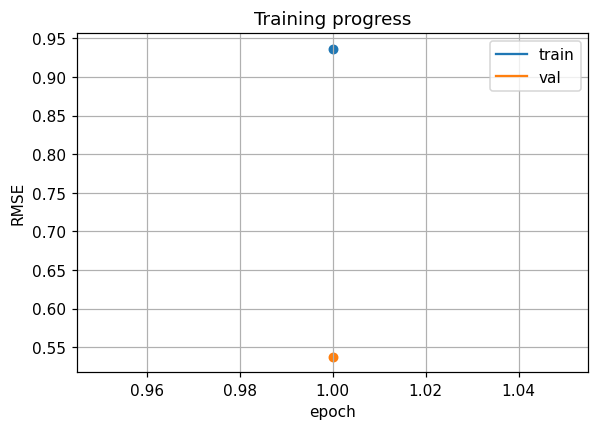

Epoch 001:   0%|                                                                              | 0/1920 [00:00<…

I0000 00:00:1750430983.725347   31314 cuda_dnn.cc:529] Loaded cuDNN version 91002


Epoch 001 • train=0.936644 • val=0.537566 • impr=-120.2% • lr=1.89e-05 • g≈49525.29


Epoch 002:   0%|                                                                              | 0/1920 [00:00<…

In [ ]:
###############################################################################
# FULL  TRAIN–SAVE  PIPELINE  – prints baseline + %-improvement               #
###############################################################################

# ─────────────────────────────────────────────────────────────────────────────
# 0.  ONE-OFF  :  baseline on the untouched validation split
# ─────────────────────────────────────────────────────────────────────────────
def naive_rmse(ds_val):
    """RMSE when the forecast is always zero."""
    mse, n = 0.0, 0
    for _, y_day, _ in ds_val:
        y = y_day.numpy().squeeze()
        mse += np.sum(y ** 2)
        n   += y.size
    return math.sqrt(mse / n)

baseline_val_rmse = naive_rmse(ds_val_unbatched)
print(f"Baseline (predict-zero) RMSE on validation = {baseline_val_rmse:.6f}")

# ─────────────────────────────────────────────────────────────────────────────
# 1.  Training loop (outer bar only → maximum throughput)                     #
# ─────────────────────────────────────────────────────────────────────────────
n_train_days = len(np.unique(day_id_tr))
print(f"Training sees {n_train_days} calendar days per epoch\n")

best_val_rmse = custom_stateful_training_loop(
        model_train         = model_train,
        model_val           = model_val,
        ds_train_batched    = ds_train_batched,
        ds_val              = ds_val_unbatched,
        n_train_days        = n_train_days,
        max_epochs          = MAX_EPOCHS,
        early_stop_patience = EARLY_STOP_PATIENCE,
        baseline_val_rmse   = baseline_val_rmse,
        ckpt_path           = ckpt_path)

print(f"\nChampion validation RMSE = {best_val_rmse:.6f}")
print(f"Improvement vs baseline   = {(1 - best_val_rmse/baseline_val_rmse)*100:5.1f} %")

# ─────────────────────────────────────────────────────────────────────────────
# 2.  Sync FP32 twin  +  refresh checkpoint                                   #
# ─────────────────────────────────────────────────────────────────────────────
model_val.set_weights(model_train.get_weights())
model_val.save_weights(ckpt_path)

# ─────────────────────────────────────────────────────────────────────────────
# 3.  Persist architecture + weights  (.keras)                                #
# ─────────────────────────────────────────────────────────────────────────────
today     = datetime.now().strftime("%Y-%m-%d")
file_path = save_dir / f"model_{ticker}_{today}.keras"
model_val.save(file_path)
print("\nModel & weights saved to", file_path)
